In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from torch.optim.lr_scheduler import StepLR
import time

In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor()) #shuffle to get different images as first image

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 15

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=6, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=False, num_workers=6, pin_memory=use_cuda)

In [4]:
class PCA(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.encoder = nn.Sequential(
            nn.Linear(IM_SIZE, dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim, IM_SIZE),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.encoder = nn.Sequential(
            nn.Linear(IM_SIZE, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, IM_SIZE),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [6]:
def train(network, dim):
    net = network(dim).to(device).train()

    optimizer = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    for epoch in range(EPOCHS):
        for X, _ in trainset:
            X = X.view(-1, IM_SIZE).to(device)
            net.zero_grad()
            output = net(X)
            loss = F.binary_cross_entropy(output, X)
            loss.backward()
            optimizer.step()
        scheduler.step()
    print(loss)
    
    return net

In [7]:
def test(net):
    net.eval()

    comp_data = np.empty((10000, net.dim))
    comp_label = np.empty((10000,))
    loss = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testset):
            X = X.view(-1, IM_SIZE).to(device)
            latent = net.encoder(X)
            output = net.decoder(latent)
            comp_data[BATCH * i: BATCH * (i + 1)] = latent.cpu()
            comp_label[BATCH * i: BATCH * (i + 1)] = y

            loss += F.mse_loss(output, X, reduction='sum')

    print(loss)
    if use_cuda:
        X = X.cpu()
        output = output.cpu()
        
    plt.subplot(141)
    plt.imshow(X[0].view(IM_SHAPE))
    plt.subplot(142)
    plt.imshow(output[0].view(IM_SHAPE))
    plt.subplot(143)
    plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,1], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
    plt.subplot(144)
    if net.dim > 2:
        plt.scatter(comp_data[0:-1:5,2], comp_data[0:-1:5,3], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)    
    plt.tight_layout()
    plt.show()


In [8]:
# Softmax - sigmoid at the last layer
# Use ReLU for all layers but the middle one
# Try to find dim 4 6 10 16 and compare to PCA
# Try to use UMAP 

dim: 4
PCA
tensor(0.6519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1658580.1250, device='cuda:0')


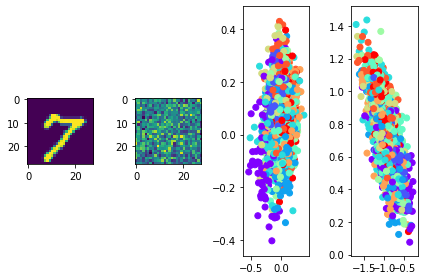

Autoencoder
tensor(0.2618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(525227.8125, device='cuda:0')


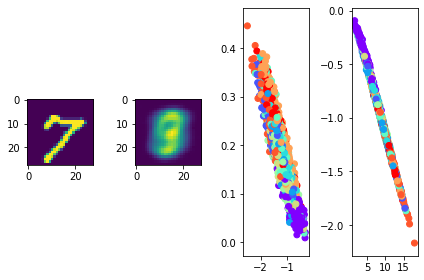

dim: 6
PCA
tensor(0.5782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1398531.3750, device='cuda:0')


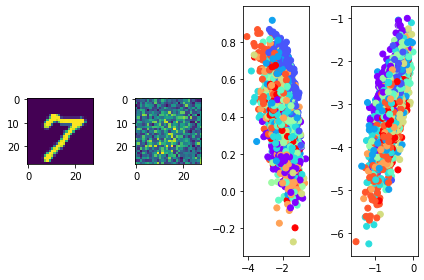

Autoencoder
tensor(0.2615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(527587., device='cuda:0')


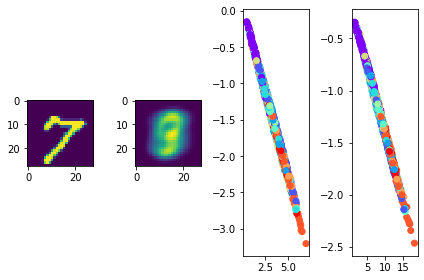

dim: 10
PCA
tensor(0.2855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(544602.2500, device='cuda:0')


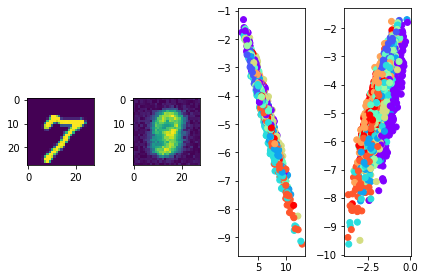

Autoencoder
tensor(0.2635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(529128.5625, device='cuda:0')


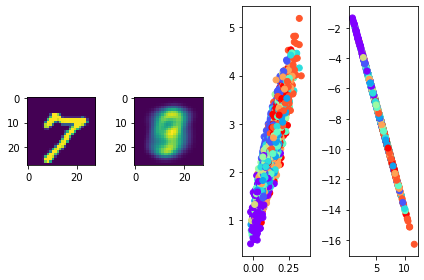

dim: 16
PCA
tensor(0.2708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(535007.0625, device='cuda:0')


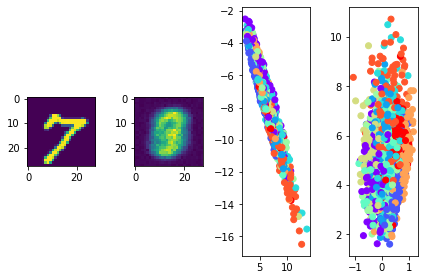

Autoencoder
tensor(0.2631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(530108.5625, device='cuda:0')


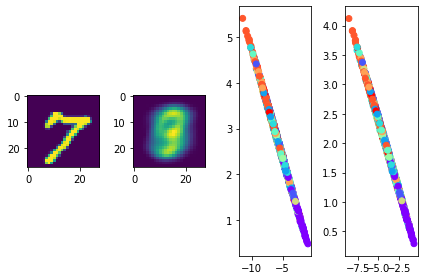

dim: 32
PCA
tensor(0.2684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(524265.8438, device='cuda:0')


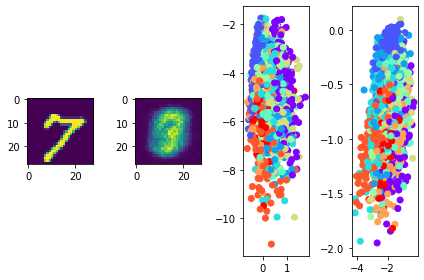

Autoencoder
tensor(0.2653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(530841.5625, device='cuda:0')


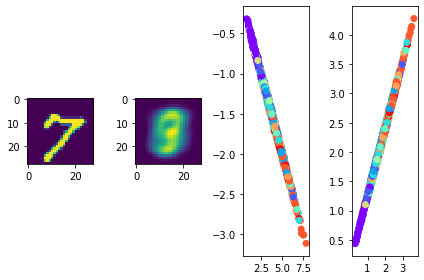

In [9]:
for dim in [2, 4, 6, 10, 16, 32]:
    print(f"dim: {dim}")
    print("PCA")
    test(train(PCA, dim))
    print("Autoencoder")
    test(train(AutoEncoder, dim))
